In [38]:
from keras.models import Sequential
from keras.layers import Dropout, Dense
from sklearn.datasets import make_regression
from talos.utils import hidden_layers
import pandas as pd

%matplotlib inline

import sys
import talos

In [39]:
#china dataset that doesn't work
#df = pd.read_csv("preproc.csv") 
#train = df.drop(['Date','1d'], axis = 1)
#y = train[train.columns[1]]
#x = train.drop(['PM2.5'], axis = 1)

#example regression dataset that works
train_x, train_y = make_regression(n_samples = 10000,
                                       n_features = number_of_features,
                                       random_state = 0)

# and normalize every feature to mean 0, std 1
x = talos.utils.rescale_meanzero(x)

In [40]:
# first we have to make sure to input data and params into the function
def create_model(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    
    # Add first hidden layer with input_dim of input features
    model.add(Dense(params['number_of_neurons'], input_dim=x_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Add second hidden layer
    model.add(Dense(params['number_of_neurons'],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Add final layer with a linear activation function
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    # Compile neural network
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['mse'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

In [41]:
# then we can go ahead and set the parameter space
p = {'number_of_neurons':[16],
     'lr': [0.001,0.01,0.1,1],
     'batch_size': [30],
     'epochs': [100],
     'dropout': [0],
     'kernel_initializer': ['uniform'],
     'optimizer': ['Adam'],
     'losses': ['mse'],
     'activation':['relu'],
     'last_activation': ['linear']}

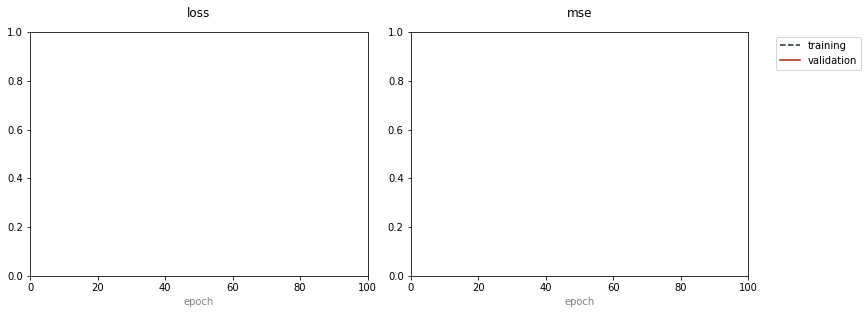



100%|██████████| 4/4 [04:27<00:00, 66.80s/it]


In [42]:
# and run the experiment
t = talos.Scan(x=x,
               y=y,
               model=create_model,
               params=p,
               experiment_name='example_run')

In [43]:
analyze_object = talos.Analyze(t)
analyze_object.data

,round_epochs,val_loss,val_mse,loss,mse,activation,batch_size,dropout,epochs,first_neuron,kernel_initializer,last_activation,losses,lr,optimizer
0,100,2388.808703,2388.808350,2408.005225,2408.006348,relu,30,0,100,16,uniform,linear,mse,0.001,Adam
1,100,2370.477620,2370.477783,2397.236928,2397.236816,relu,30,0,100,16,uniform,linear,mse,0.010,Adam
2,100,2446.780623,2446.781494,2498.354331,2498.355469,relu,30,0,100,16,uniform,linear,mse,0.100,Adam
3,100,2383.958007,2383.958496,2396.306059,2396.306396,relu,30,0,100,16,uniform,linear,mse,1.000,Adam


In [44]:
analyze_object.low('val_loss')

2370.477619643296